In [1]:
from datetime import date, timedelta, datetime
from pyspark.sql.functions import collect_list
from pyspark.sql import Row
import pandas as pd
import numpy as np
import ujson as json
import os.path
from collections import Counter
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
def int2date(n):
    """
    This function converts a number of days since Jan 1st 1970 <n> to a date.
    """
    try:
        return date(1970,1,1)+timedelta(days=n)
    except:
        return date(1970,1,1)

def date2int(d):
    """
    This function converts a date <d> to number of days since Jan 1st 1970.
    """
    try:
        return (d-date(1970,1,1)).days
    except:
        return -1

def str2date(s, f="%Y%m%d"):
    """
    This function converts a string <s> in the format <f> to a date.
    """
    try:
        return datetime.strptime(s, f).date()
    except:
        return ""

TODAY = date.today()                                    # today (date)
TODAY_INT = date2int(TODAY)                             # today (days since Jan 1st, 1970)
D0 = date(2016, 12, 12)                                 # start date of week of analysis (date)
D0_INT = date2int(D0)                                   # start date of week of analysis (days since Jan 1st, 1970)
PCD_CUTOUT_START_DATE = date(2010, 1, 1)                # profiles created before this date are removed (date)
PCD_CUTOUT_START_INT = date2int(PCD_CUTOUT_START_DATE)  # profiles created before this date are removed (days since Jan 1st, 1970)
T0 = 180                                                # time to consider stop using Fx
D0_T0 = D0 - timedelta(days=T0)                         # date beginning of stoppage period (date)
D0_T0_INT = D0_INT - T0                                 # date beginning of stoppage period (days since Jan 1st, 1970)
D6 = D0 + timedelta(days=6)                             # date end of week of analysis (date)
D6_INT = D0_INT + 6                                     # date end of week of analysis (days since Jan 1st, 1970)

In [3]:
allPingsDF = sqlContext.read.load("s3://telemetry-parquet/main_summary/v3", "parquet", mergeSchema=True)
    
# perform variable selection with column renaming
allPingsDFSelect = allPingsDF.select(
           allPingsDF.client_id.alias("cid"),
           allPingsDF.sample_id.alias("sid"),
           allPingsDF.normalized_channel.alias("channel"),
           allPingsDF.subsession_start_date.alias("ssd"),
           allPingsDF.app_name.alias("appname"),
           allPingsDF.subsession_length.alias("ssl"),
           allPingsDF.profile_creation_date.alias("pcd"),
           allPingsDF.app_version.alias("av"))

# filter, replace missing values with zeroes, and cache dataframe
# - 1% sample (sample_id is 42)
# - channel is release
# - application is Firefox
# - subsession length is positive and less than 24h
# - profile creation date is after Jan 1st, 2010 and before TODAY, either before D0-T0 or after D0 (during week of analysis)
# Dataframe is `cache`d to memory for performance improvements
filteredPingsDF = allPingsDFSelect.filter(allPingsDFSelect.sid == "42")\
                                  .filter(allPingsDFSelect.channel == "release")\
                                  .filter(allPingsDFSelect.appname == "Firefox")\
                                  .filter(allPingsDFSelect.ssl >= 0)\
                                  .filter(allPingsDFSelect.ssl <= 86400)\
                                  .filter(allPingsDFSelect.pcd >= PCD_CUTOUT_START_INT)\
                                  .filter(allPingsDFSelect.pcd <= TODAY_INT)\
                                  .filter(~allPingsDFSelect.pcd.isin(range(D0_T0_INT, D0_INT)))\
                                  .select(["cid","ssd","pcd","ssl","av"])\
                                  .cache()

In [4]:
filteredPingsDF.count() # ~1B pings

1069834699

In [5]:
filteredPingsDF.take(10)

[Row(cid=u'f2477312-822f-4ff2-bc64-da937cfa65c0', ssd=u'2017-01-11T00:00:00.0-08:00', pcd=16302, ssl=78, av=u'50.1.0'),
 Row(cid=u'16c632e6-4894-420f-a36e-959becfe1e0a', ssd=u'2017-01-11T00:00:00.0+01:00', pcd=16751, ssl=222, av=u'50.1.0'),
 Row(cid=u'bbe11592-0a14-7a44-9378-6da30333c44d', ssd=u'2017-01-12T00:00:00.0+09:00', pcd=16310, ssl=263, av=u'50.1.0'),
 Row(cid=u'65711634-f4b2-466a-aeb2-7c11b8d0609f', ssd=u'2017-01-11T00:00:00.0+01:00', pcd=16203, ssl=23532, av=u'50.1.0'),
 Row(cid=u'208d975e-87dc-4744-adaa-54f0bbb4e4db', ssd=u'2017-01-11T00:00:00.0+03:00', pcd=16317, ssl=18973, av=u'50.1.0'),
 Row(cid=u'b3ef7ee1-2767-4d9e-9137-e9937fa3be9b', ssd=u'2017-01-11T00:00:00.0+03:00', pcd=16589, ssl=742, av=u'50.1.0'),
 Row(cid=u'1dee170b-7978-4c85-81b2-d8718d6acb69', ssd=u'2017-01-11T00:00:00.0-08:00', pcd=17169, ssl=56, av=u'50.1.0'),
 Row(cid=u'65c3072a-36e8-4e96-89e7-3b0a0b8131b0', ssd=u'2017-01-11T00:00:00.0+02:00', pcd=16461, ssl=50, av=u'50.1.0'),
 Row(cid=u'1dee170b-7978-4c85-8

In [6]:
filteredPingsDF.groupBy("cid").count().count() # 5M (*100) users

5722003

In [4]:
longitudinal = filteredPingsDF.groupBy("cid")\
                              .agg({"ssl": "collect_list",
                                    "ssd": "collect_list",
                                    "av": "collect_list",
                                    "pcd": "first"})\
                              .withColumnRenamed("first(pcd)","pcd")\
                              .withColumnRenamed("collect_list(ssl)","ssl")\
                              .withColumnRenamed("collect_list(ssd)","ssd")\
                              .withColumnRenamed("collect_list(av)","av")

In [8]:
t=longitudinal.take(1)[0]
t

Row(cid=u'00018e0c-b07f-4097-89cb-5910a95002f2', pcd=16317, av=[u'49.0.1', u'49.0.1', u'47.0.1', u'47.0.1', u'47.0.1', u'47.0.1', u'48.0.2', u'48.0.2', u'48.0.2', u'48.0.2', u'48.0.2', u'48.0.2', u'48.0.2', u'48.0.2', u'48.0.2', u'48.0.2', u'48.0.2', u'48.0.2', u'51.0.1', u'51.0.1', u'51.0.1', u'51.0.1', u'51.0.1', u'51.0.1', u'47.0', u'49.0.2', u'49.0.2', u'49.0.2', u'49.0.2', u'49.0.2', u'49.0.2', u'49.0.2', u'50.1.0', u'50.1.0', u'50.1.0', u'50.1.0', u'50.1.0', u'50.1.0', u'50.1.0', u'50.1.0', u'50.1.0', u'50.1.0', u'50.1.0', u'50.1.0', u'46.0.1', u'46.0.1', u'46.0.1', u'47.0', u'46.0.1', u'46.0.1', u'46.0.1', u'46.0.1', u'46.0.1', u'46.0.1', u'46.0.1', u'45.0.1', u'47.0', u'47.0', u'47.0', u'47.0', u'47.0', u'47.0', u'47.0', u'46.0.1', u'46.0.1', u'49.0.2', u'49.0.2', u'49.0.2', u'49.0.2', u'49.0.2', u'49.0.2', u'49.0.2', u'45.0.2', u'45.0.2', u'51.0.1', u'51.0.1', u'51.0.1', u'51.0.1', u'51.0.1', u'51.0.1', u'50.0.2', u'50.0.2', u'50.0', u'49.0.2', u'45.0.2', u'45.0.1', u'45.0.1',

In [9]:
#[s[:10] for s in sorted(t.ssd)]

In [10]:
#set([(D0 + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((D6-D0).days + 1)]) & set(["2017-12-12"])

In [11]:
#D0_T0.strftime("%Y-%m-%d")

In [5]:
def mapping(row):
    """
    Applied to an RDD, this mapping function returns a tuple of seven elements for each Row of the dataframe:
        - cohort: [string] One of {'no: active s','no: inactive b','no: inactive w',
                                   'no: pcd in s','yes: active b, inactive s, active w','yes: pcd in w'}
        - cid: [string] Client_id
        - pcd: [int] Profile creation date (in days since Jan 1st, 1970)
        - ssd: [list] List of all subsession start dates (ascending)
        - ssl: [list] List of all subsession lengths (ordered with repect to ssd) 
        - pcd_date: [date] Profile creation date (as datetime.date)
        - num_ssd_in_w: [int] Number of subsessions that started in the week of interest
        - tot_ssl_in_w: [int] Sum of subsession lengths within the week of interest
        - num_ssd_in_b: [int] Number of subsessions before D0-T0
        - tot_ssl_in_b: [int] Sum of subsession lengths before D0-T0
    
    @params:
        row: [Row] a row from a longitudinal RDD that includes:
            - cid: client_id
            - ssl: subsession_length
            - ssd: subsession_start_date
            - pcd: profile_creation_date
            - av: app_version
    
    @logic:
        - sort the row based on ssd (ascending). Keep only entries up to D6 (end of week of analysis)
        - if pcd within the week: update cohort ("yes")
        - else
            - if user was
                - not active during the week of analysis,
                - OR active during [D0-T0, D0],
                - OR not active before D0-T0
                - THEN update cohort ("no")
            - else: update cohort ("yes")
    """
    
    def sort_row(row):
        # sort ssd and ssl by descending ssd
        zipped = sorted(zip(row.ssd, row.ssl, row.av), reverse=False)
        ssd, ssl, av = zip(*zipped)
        
        # keep only subsessions that started before the end of the week of interest
        ssd = [s[:10] for s in ssd if s[:10] <= D6.strftime("%Y-%m-%d")]
        
        # trim ssl, av (since it was sorted in ascending fashion, trim the end)
        ssl = ssl[:len(ssd)]
        av = av[:len(ssd)]
        
        # indices within week of analysis
        indices_in_w = [i for i in range(len(row.ssd)) if row.ssd[i][:10]<=D6.strftime("%Y-%m-%d") and row.ssd[i][:10]>=D0.strftime("%Y-%m-%d")]
        # indices before D0-T0
        indices_in_b = [i for i in range(len(row.ssd)) if row.ssd[i][:10]<=D0_T0.strftime("%Y-%m-%d")]
        
        # ssd, ssl, av for each period
        ssd_in_w = [row.ssd[i][:10] for i in indices_in_w]
        ssl_in_w = [row.ssl[i] for i in indices_in_w]
        av_in_w = [row.av[i] for i in indices_in_w]
        ssd_in_b = [row.ssd[i][:10] for i in indices_in_b]
        ssl_in_b = [row.ssl[i] for i in indices_in_b]
        av_in_b = [row.av[i] for i in indices_in_b]
        
        # return reformatted Row with additional info
        return Row(cid=row.cid,
                   pcd=row.pcd,
                   ssd=list(ssd),
                   ssl=list(ssl),
                   av=list(av),
                   av_in_w=av_in_w,
                   av_in_b=av_in_b,
                   pcd_date=int2date(row.pcd),
                   ssd_in_w=ssd_in_w,
                   ssd_in_b=ssd_in_b,
                   num_ssd_in_w=len(ssd_in_w),
                   tot_ssl_in_w=sum(ssl_in_w),
                   num_ssd_in_b=len(ssd_in_b),
                   tot_ssl_in_b=sum(ssl_in_b))
    
    cohort = ""
    last_version_in_b = "NA"
    first_version_in_w = "NA"
    days_in_s = 0
    
    s_row = sort_row(row)
    
    if s_row.pcd >= D0_INT and s_row.pcd <= D6_INT:
        cohort = "yes: pcd in w"
        #first_version_in_w = s_row.av_in_w[0]
    elif s_row.pcd <= D0_T0_INT:
        week = [(D0 + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((D6-D0).days + 1)]
        stagnant = [(D0_T0 + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(1, (D0-D0_T0).days)]
        beginning = [(s_row.pcd_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((D0_T0-s_row.pcd_date).days +1)]
        set_ssd = set(s_row.ssd)
        if len(set(week) & set_ssd) == 0: # not active during week
            cohort = "no: inactive w"
        elif len(set(stagnant) & set_ssd) > 0: # active during stagnant
            cohort = "no: active s"
        elif len(set(beginning) & set_ssd) == 0: # not active during beginning
            cohort = "no: inactive b"
        else:
            cohort = "yes: active b, inactive s, active w"
            last_version_in_b = s_row.av_in_b[-1]
            first_version_in_w = s_row.av_in_w[0]
            last_day_in_b = s_row.ssd_in_b[-1]
            first_day_in_w = s_row.ssd_in_w[0]
            days_in_s = (datetime.strptime(first_day_in_w, "%Y-%m-%d") - datetime.strptime(last_day_in_b, "%Y-%m-%d")).days
    else:
        cohort = "no: pcd in s"
    
    return (cohort,                 # cohort
            last_version_in_b,      # last Fx version in beginning
            first_version_in_w,     # first Fx version in week of interest
            s_row.cid,              # cid
            s_row.pcd,              # pcd (days since Jan 1st, 1970)
            s_row.ssd,              # list of ssd (ascending)
            s_row.ssl,              # list of ssl (based on ssd)
            s_row.av,               # list of av (based on ssd)
            s_row.pcd_date,         # pcd (date)
            s_row.num_ssd_in_w,     # number of days in week of analysis
            s_row.tot_ssl_in_w,     # total ssl in week of analysis
            s_row.num_ssd_in_b,     # number of days before D0-T0
            s_row.tot_ssl_in_b,     # total ssl before D0-T0
            days_in_s)              # days spent without use of Fx

In [6]:
mapped = longitudinal.rdd.map(mapping)

In [28]:
mapped.first()

('no: active s',
 'NA',
 'NA',
 u'00018e0c-b07f-4097-89cb-5910a95002f2',
 16317,
 [u'2016-03-11',
  u'2016-03-12',
  u'2016-03-12',
  u'2016-03-12',
  u'2016-03-12',
  u'2016-03-12',
  u'2016-03-12',
  u'2016-03-12',
  u'2016-03-12',
  u'2016-03-12',
  u'2016-03-12',
  u'2016-03-12',
  u'2016-03-12',
  u'2016-03-12',
  u'2016-03-13',
  u'2016-03-13',
  u'2016-03-13',
  u'2016-03-13',
  u'2016-03-13',
  u'2016-03-13',
  u'2016-03-15',
  u'2016-03-15',
  u'2016-03-15',
  u'2016-03-15',
  u'2016-03-15',
  u'2016-03-15',
  u'2016-03-15',
  u'2016-03-15',
  u'2016-03-15',
  u'2016-03-15',
  u'2016-03-16',
  u'2016-03-16',
  u'2016-03-17',
  u'2016-03-18',
  u'2016-03-20',
  u'2016-03-22',
  u'2016-03-22',
  u'2016-03-22',
  u'2016-03-22',
  u'2016-03-22',
  u'2016-03-23',
  u'2016-03-25',
  u'2016-03-28',
  u'2016-03-28',
  u'2016-03-28',
  u'2016-03-28',
  u'2016-03-28',
  u'2016-03-28',
  u'2016-03-28',
  u'2016-03-28',
  u'2016-03-29',
  u'2016-03-29',
  u'2016-03-29',
  u'2016-03-29',
 

In [22]:
mapped.countByKey()

#'no: active s': 1,438,466
#'no: inactive b': 14,371
#'no: inactive w': 3,299,290
#'no: pcd in s': 694,566
#'yes: active b, inactive s, active w': 6,436
#'yes: pcd in w': 91,403

## sum = 5,544,532 (no: 5,446,693, yes: 97,839)
## users = 5,544,532

defaultdict(int,
            {'no: active s': 1443767,
             'no: inactive b': 14427,
             'no: inactive w': 3319708,
             'no: pcd in s': 845719,
             'yes: active b, inactive s, active w': 6521,
             'yes: pcd in w': 91861})

In [7]:
positives = mapped.filter(lambda row: row[0].startswith("yes"))

In [8]:
positives.first()

('yes: pcd in w',
 'NA',
 'NA',
 u'0094863c-0b40-c44d-8334-cf4971daf152',
 17151,
 [u'2016-12-16', u'2016-12-16', u'2016-12-16', u'2016-12-16'],
 [103, 311, 500, 1270],
 [u'50.1.0', u'50.1.0', u'50.1.0', u'50.1.0'],
 datetime.date(2016, 12, 16),
 4,
 2184,
 0,
 0,
 0)

In [ ]:
c = mapped.filter(lambda row: row[0] == "yes: active b, inactive s, active w")

In [ ]:
c.count()

In [9]:
# takes forever
positives_pd = positives.toDF(["cohort",
                               "last_version_in_b",
                               "first_version_in_w",
                               "cid",
                               "pcd",
                               "ssd",
                               "ssl",
                               "av",
                               "pcd_date",
                               "num_ssd_in_w",
                               "tot_ssl_in_w",
                               "num_ssd_in_b",
                               "tot_ssl_in_b",
                               "days_in_s"]).toPandas()

In [10]:
positives_pd # 98,379 rows

,cohort,last_version_in_b,first_version_in_w,cid,pcd,ssd,ssl,av,pcd_date,num_ssd_in_w,tot_ssl_in_w,num_ssd_in_b,tot_ssl_in_b,days_in_s
0,yes: pcd in w,NA,NA,0094863c-0b40-c44d-8334-cf4971daf152,17151,"[2016-12-16, 2016-12-16, 2016-12-16, 2016-12-16]","[103, 311, 500, 1270]","[50.1.0, 50.1.0, 50.1.0, 50.1.0]",2016-12-16,4,2184,0,0,0
1,yes: pcd in w,NA,NA,00ce7e08-ac7f-4581-bc27-6b82b7b67110,17152,[2016-12-17],[63],[50.1.0],2016-12-17,1,63,0,0,0
2,yes: pcd in w,NA,NA,0146939e-d460-4487-af8b-5e5bc246495d,17152,"[2016-12-17, 2016-12-17, 2016-12-17, 2016-12-1...","[16, 20, 23, 31, 63, 219, 246, 305, 352, 370, ...","[50.1.0, 50.1.0, 50.1.0, 50.1.0, 50.1.0, 50.1....",2016-12-17,38,47977,0,0,0
3,yes: pcd in w,NA,NA,01b5669a-a9f0-4086-aa82-382a0d028ede,17149,[2016-12-14],[63],[46.0.1],2016-12-14,1,63,0,0,0
4,yes: pcd in w,NA,NA,01d91858-7bf6-48f0-941f-492ea9aa9d95,17151,"[2016-12-16, 2016-12-16]","[63, 658]","[50.0, 50.0]",2016-12-16,2,721,0,0,0
5,yes: pcd in w,NA,NA,0290eb86-c4da-449f-a973-fd1039d0344c,17151,"[2016-12-15, 2016-12-15]","[70, 533]","[50.1.0, 50.1.0]",2016-12-16,2,603,0,0,0
6,yes: pcd in w,NA,NA,02c06272-c537-4396-a69c-f64e1cfc0178,17147,"[2016-12-12, 2016-12-12, 2016-12-12, 2016-12-1...","[84, 148, 407, 9417, 21, 33, 582, 27, 2869]","[50.0.2, 50.0.2, 50.0.2, 50.0.2, 50.0.2, 50.0....",2016-12-12,9,13588,0,0,0
7,yes: pcd in w,NA,NA,030f11c4-7866-4e6c-9756-c3ae5a73a082,17149,"[2016-12-13, 2016-12-13, 2016-12-13, 2016-12-1...","[4, 12, 35, 45, 60, 115, 147, 337, 500, 2650, ...","[50.0.2, 50.0.2, 50.0.2, 50.0.2, 50.0.2, 50.0....",2016-12-14,12,29213,0,0,0
8,yes: pcd in w,NA,NA,03c89450-2914-40c6-987c-6ec219cf2085,17150,"[2016-12-15, 2016-12-15, 2016-12-15]","[6, 64, 198]","[50.1.0, 50.1.0, 50.1.0]",2016-12-15,3,268,0,0,0
9,"yes: active b, inactive s, active w",41.0.2,41.0.2,0479f749-d04c-4905-9d69-9781c2b96895,16872,"[2016-05-18, 2016-05-25, 2016-12-15, 2016-12-15]","[833, 43, 559, 736]","[41.0.2, 41.0.2, 41.0.2, 41.0.2]",2016-03-12,2,1295,2,876,211


In [11]:
cohort1 = positives_pd[positives_pd.cohort == "yes: active b, inactive s, active w"]

In [263]:
#cohort1.shape[0]

In [12]:
cohort1 # 6,520 rows

,cohort,last_version_in_b,first_version_in_w,cid,pcd,ssd,ssl,av,pcd_date,num_ssd_in_w,tot_ssl_in_w,num_ssd_in_b,tot_ssl_in_b,days_in_s
9,"yes: active b, inactive s, active w",41.0.2,41.0.2,0479f749-d04c-4905-9d69-9781c2b96895,16872,"[2016-05-18, 2016-05-25, 2016-12-15, 2016-12-15]","[833, 43, 559, 736]","[41.0.2, 41.0.2, 41.0.2, 41.0.2]",2016-03-12,2,1295,2,876,211
16,"yes: active b, inactive s, active w",44.0.2,44.0.2,07351215-6767-402c-b2ad-77359d3c0dd2,16486,"[2016-03-10, 2016-12-14]","[224, 583]","[44.0.2, 44.0.2]",2015-02-20,1,583,1,224,279
18,"yes: active b, inactive s, active w",45.0.1,48.0.2,07e60027-9a2d-4866-8461-1052fee90956,16932,"[2016-05-11, 2016-12-14]","[423, 94]","[45.0.1, 48.0.2]",2016-05-11,1,94,1,423,217
27,"yes: active b, inactive s, active w",47.0,47.0,0b6ff27a-450e-4dd5-995b-ac4c5ffcc0e9,16959,"[2016-06-07, 2016-06-07, 2016-06-07, 2016-06-0...","[23, 56, 116, 273, 72]","[47.0, 47.0, 47.0, 47.0, 47.0]",2016-06-07,1,72,4,468,188
69,"yes: active b, inactive s, active w",47.0,47.0,215cbf09-aff0-4ffd-bb1e-b8fb6e72a747,16842,"[2016-02-11, 2016-02-27, 2016-02-27, 2016-12-1...","[360, 79, 1782, 23, 111, 155, 360, 960, 1260]","[47.0, 47.0, 47.0, 47.0, 47.0, 47.0, 47.0, 47....",2016-02-11,6,2869,3,2221,294
83,"yes: active b, inactive s, active w",42.0,42.0,262b3334-0729-40ce-90ba-525f87a1fa0e,16111,"[2016-03-10, 2016-12-14]","[1223, 847]","[42.0, 42.0]",2014-02-10,1,847,1,1223,279
116,"yes: active b, inactive s, active w",42.0,42.0,37daaba9-1272-6b44-840d-824ece8d0ea0,15338,"[2016-06-01, 2016-06-01, 2016-12-17]","[722, 1372, 722]","[42.0, 42.0, 42.0]",2011-12-30,1,722,2,2094,199
131,"yes: active b, inactive s, active w",44.0.2,44.0.2,42e413f4-d5ec-49c5-a87f-d44d7aae6384,16843,"[2016-02-12, 2016-04-15, 2016-04-15, 2016-06-1...","[33, 41, 605, 74, 843]","[44.0.2, 44.0.2, 44.0.2, 44.0.2, 44.0.2]",2016-02-12,1,843,4,753,243
137,"yes: active b, inactive s, active w",44.0.2,50.1.0,456304fe-eb02-46b6-a235-f6eae8ca5f08,16651,"[2016-03-11, 2016-12-14]","[159, 14]","[44.0.2, 50.1.0]",2015-08-04,1,14,1,159,278
143,"yes: active b, inactive s, active w",47.0,47.0,489ad739-6b25-4dec-8781-c7937966824b,16963,"[2016-06-11, 2016-06-11, 2016-06-11, 2016-12-1...","[72, 533, 8263, 78, 536, 6300]","[47.0, 47.0, 47.0, 47.0, 47.0, 47.0]",2016-06-11,3,6914,3,8868,185


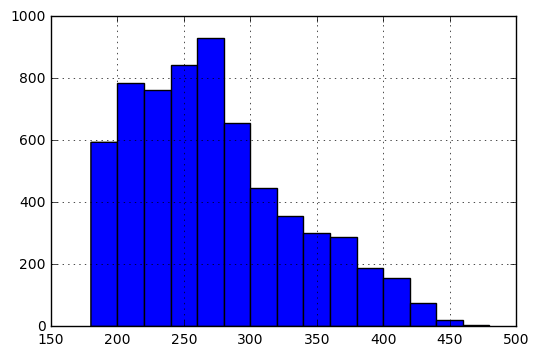

In [19]:
cohort1.days_in_s.hist(bins=range(180,500,20))

In [20]:
upgraded_fx = cohort1[cohort1.last_version_in_b != cohort1.first_version_in_w]

In [21]:
upgraded_fx # 3,551 rows

,cohort,last_version_in_b,first_version_in_w,cid,pcd,ssd,ssl,av,pcd_date,num_ssd_in_w,tot_ssl_in_w,num_ssd_in_b,tot_ssl_in_b,days_in_s
18,"yes: active b, inactive s, active w",45.0.1,48.0.2,07e60027-9a2d-4866-8461-1052fee90956,16932,"[2016-05-11, 2016-12-14]","[423, 94]","[45.0.1, 48.0.2]",2016-05-11,1,94,1,423,217
137,"yes: active b, inactive s, active w",44.0.2,50.1.0,456304fe-eb02-46b6-a235-f6eae8ca5f08,16651,"[2016-03-11, 2016-12-14]","[159, 14]","[44.0.2, 50.1.0]",2015-08-04,1,14,1,159,278
203,"yes: active b, inactive s, active w",42.0,50.0.2,644eb7df-e59d-49fb-b682-4b7d6aa357c2,16778,"[2015-12-09, 2016-12-13]","[451, 65]","[42.0, 50.0.2]",2015-12-09,1,65,1,451,370
225,"yes: active b, inactive s, active w",42.0,50.1.0,6da3599c-574d-9e44-83f5-676615650e82,16772,"[2016-02-26, 2016-03-31, 2016-03-31, 2016-03-3...","[6373, 203, 732, 1386, 24894, 0, 10395, 4060, ...","[42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42....",2015-12-03,12,7303,36,110495,218
255,"yes: active b, inactive s, active w",43.0.1,46.0.1,829187db-bfc0-480a-8b87-3e31db8a381d,15536,"[2016-04-12, 2016-12-15]","[14, 28422]","[43.0.1, 46.0.1]",2012-07-15,1,28422,1,14,247
260,"yes: active b, inactive s, active w",43.0.1,46.0.1,83f2fa34-7d00-4428-9edb-2d101dd5f553,16643,"[2016-06-02, 2016-06-02, 2016-06-02, 2016-12-1...","[81, 642, 28919, 64, 77, 77]","[43.0.1, 43.0.1, 43.0.1, 46.0.1, 46.0.1, 46.0.1]",2015-07-27,3,218,3,29642,194
295,"yes: active b, inactive s, active w",42.0,43.0.1,94babfc5-77db-4899-9e0c-8328d2bff41a,16778,"[2016-02-10, 2016-12-15]","[19375, 166]","[42.0, 43.0.1]",2015-12-09,1,166,1,19375,309
304,"yes: active b, inactive s, active w",43.0.1,50.0.2,9a8afbb7-3435-4ce3-bc0c-fd5698c7bdff,16090,"[2016-01-04, 2016-01-04, 2016-01-05, 2016-12-1...","[22, 68379, 2586, 125, 146, 36746, 30, 2555, 1...","[43.0.1, 43.0.1, 43.0.1, 50.0.2, 50.0.2, 50.0....",2014-01-20,16,173776,3,70987,347
307,"yes: active b, inactive s, active w",42.0,48.0,9b7ef8d6-82cf-4a84-bfcb-6bef07f0d2f4,16534,"[2015-11-15, 2015-11-21, 2015-12-04, 2015-12-2...","[26183, 13, 3724, 14, 60, 30, 68]","[42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 48.0]",2015-04-09,1,68,6,30024,398
355,"yes: active b, inactive s, active w",42.0,43.0.1,b0445bec-42bf-4295-874c-4bd118d04c58,16369,"[2016-03-15, 2016-03-15, 2016-03-15, 2016-03-1...","[255, 317, 2137, 34, 57, 368, 388, 170, 845, 4...","[42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42....",2014-10-26,4,7039,8,3726,272


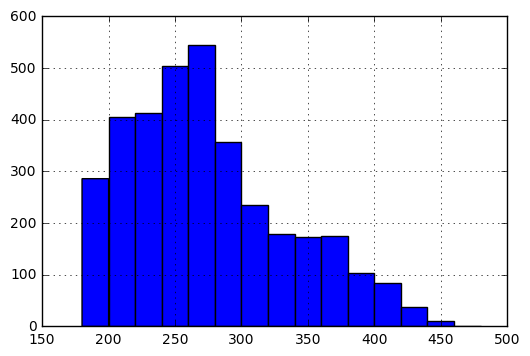

In [22]:
upgraded_fx.days_in_s.hist(bins=range(180,500,20))

In [23]:
not_upgraded_fx = cohort1[cohort1.last_version_in_b == cohort1.first_version_in_w]

In [24]:
not_upgraded_fx # 2,983

,cohort,last_version_in_b,first_version_in_w,cid,pcd,ssd,ssl,av,pcd_date,num_ssd_in_w,tot_ssl_in_w,num_ssd_in_b,tot_ssl_in_b,days_in_s
9,"yes: active b, inactive s, active w",41.0.2,41.0.2,0479f749-d04c-4905-9d69-9781c2b96895,16872,"[2016-05-18, 2016-05-25, 2016-12-15, 2016-12-15]","[833, 43, 559, 736]","[41.0.2, 41.0.2, 41.0.2, 41.0.2]",2016-03-12,2,1295,2,876,211
16,"yes: active b, inactive s, active w",44.0.2,44.0.2,07351215-6767-402c-b2ad-77359d3c0dd2,16486,"[2016-03-10, 2016-12-14]","[224, 583]","[44.0.2, 44.0.2]",2015-02-20,1,583,1,224,279
27,"yes: active b, inactive s, active w",47.0,47.0,0b6ff27a-450e-4dd5-995b-ac4c5ffcc0e9,16959,"[2016-06-07, 2016-06-07, 2016-06-07, 2016-06-0...","[23, 56, 116, 273, 72]","[47.0, 47.0, 47.0, 47.0, 47.0]",2016-06-07,1,72,4,468,188
69,"yes: active b, inactive s, active w",47.0,47.0,215cbf09-aff0-4ffd-bb1e-b8fb6e72a747,16842,"[2016-02-11, 2016-02-27, 2016-02-27, 2016-12-1...","[360, 79, 1782, 23, 111, 155, 360, 960, 1260]","[47.0, 47.0, 47.0, 47.0, 47.0, 47.0, 47.0, 47....",2016-02-11,6,2869,3,2221,294
83,"yes: active b, inactive s, active w",42.0,42.0,262b3334-0729-40ce-90ba-525f87a1fa0e,16111,"[2016-03-10, 2016-12-14]","[1223, 847]","[42.0, 42.0]",2014-02-10,1,847,1,1223,279
116,"yes: active b, inactive s, active w",42.0,42.0,37daaba9-1272-6b44-840d-824ece8d0ea0,15338,"[2016-06-01, 2016-06-01, 2016-12-17]","[722, 1372, 722]","[42.0, 42.0, 42.0]",2011-12-30,1,722,2,2094,199
131,"yes: active b, inactive s, active w",44.0.2,44.0.2,42e413f4-d5ec-49c5-a87f-d44d7aae6384,16843,"[2016-02-12, 2016-04-15, 2016-04-15, 2016-06-1...","[33, 41, 605, 74, 843]","[44.0.2, 44.0.2, 44.0.2, 44.0.2, 44.0.2]",2016-02-12,1,843,4,753,243
143,"yes: active b, inactive s, active w",47.0,47.0,489ad739-6b25-4dec-8781-c7937966824b,16963,"[2016-06-11, 2016-06-11, 2016-06-11, 2016-12-1...","[72, 533, 8263, 78, 536, 6300]","[47.0, 47.0, 47.0, 47.0, 47.0, 47.0]",2016-06-11,3,6914,3,8868,185
159,"yes: active b, inactive s, active w",44.0.2,44.0.2,4ff9875d-e51b-4114-975e-20747c9e4a39,15239,"[2016-03-07, 2016-03-07, 2016-03-07, 2016-03-0...","[2, 7, 12, 20, 26, 6232, 93, 562, 28190, 97, 1...","[43.0.4, 43.0.4, 43.0.4, 43.0.4, 43.0.4, 43.0....",2011-09-22,1,98,17,42113,205
195,"yes: active b, inactive s, active w",43.0.1,43.0.1,5e7b7381-a956-4ba3-b48c-304f8ffd7d7b,16218,"[2016-02-24, 2016-12-12, 2016-12-12, 2016-12-1...","[792, 11, 82, 222, 725, 18]","[43.0.1, 43.0.1, 43.0.1, 43.0.1, 43.0.1, 43.0.1]",2014-05-28,5,1058,1,792,296


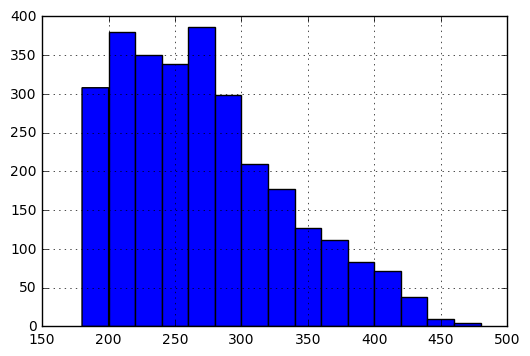

In [25]:
not_upgraded_fx.days_in_s.hist(bins=range(180,500,20))

In [34]:
print cohort1.days_in_s.describe()
print upgraded_fx.days_in_s.describe()
print not_upgraded_fx.days_in_s.describe()

count    6521.000000
mean      296.494403
std       201.432159
min       180.000000
25%       227.000000
50%       266.000000
75%       314.000000
max      2541.000000
Name: days_in_s, dtype: float64
count    3538.000000
mean      283.992369
std       138.017723
min       180.000000
25%       230.000000
50%       267.000000
75%       309.000000
max      2541.000000
Name: days_in_s, dtype: float64
count    2983.000000
mean      311.322494
std       256.350360
min       180.000000
25%       224.000000
50%       266.000000
75%       317.000000
max      2540.000000
Name: days_in_s, dtype: float64


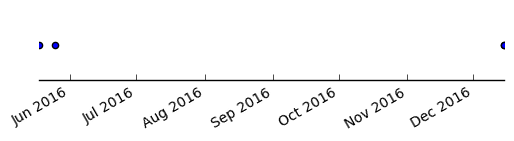

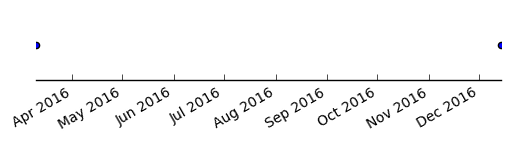

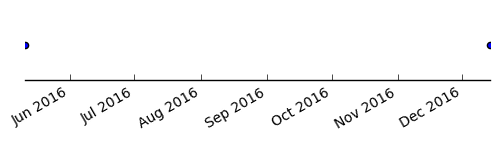

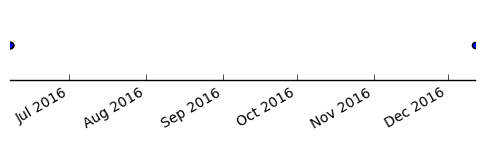

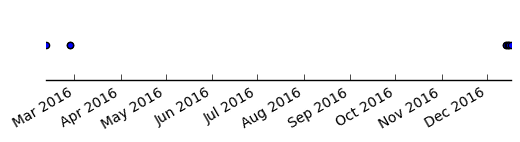

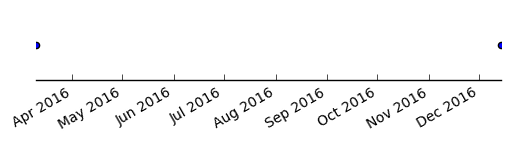

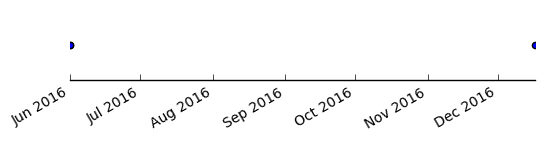

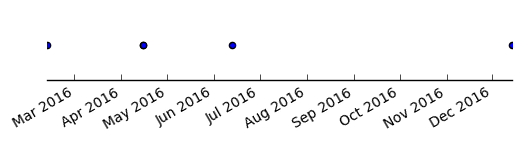

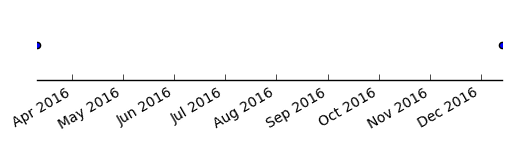

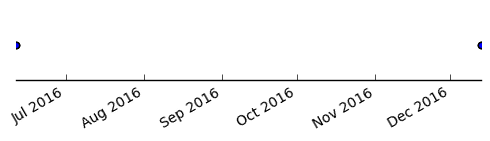

In [35]:
for i in range(10):
    dates = list(cohort1.iloc[i].ssd)

    X = pd.to_datetime(dates)
    fig, ax = plt.subplots(figsize=(6,1))
    ax.scatter(X, [1]*len(X))
    fig.autofmt_xdate()

    # everything after this is turning off stuff that's plotted by default

    ax.yaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')

    ax.get_yaxis().set_ticklabels([])
    day = pd.to_timedelta("1", unit='D')
    plt.xlim(X[0] - day, X[-1] + day)
    plt.show()

In [37]:
# average length per subsession during week of analysis
pd.DataFrame({"avg(ssl) in w": cohort1.tot_ssl_in_w/cohort1.num_ssd_in_w,
              "avg(ssl) in b": cohort1.tot_ssl_in_b/cohort1.num_ssd_in_b})

,avg(ssl) in b,avg(ssl) in w
9,438.000000,647.500000
16,224.000000,583.000000
18,423.000000,94.000000
27,117.000000,72.000000
69,740.333333,478.166667
83,1223.000000,847.000000
116,1047.000000,722.000000
131,188.250000,843.000000
137,159.000000,14.000000
143,2956.000000,2304.666667
